We want to calculate the covariance matrix of our background data.



Fun fact: our covariance array is a Toeplitz matrix

In [155]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [156]:
full_time_series = torch.from_numpy(np.loadtxt("./data/background_0.dat", dtype=np.float32))
full_time_series = full_time_series.to(device)

time_series = full_time_series

In [172]:
try:
    torch.cuda.reset_peak_memory_stats()
except:
    print("Cuda not supported or something like that")

cov_mat_row_one = []
means = []

sliding_window_size = 1000
batch_size = 100 # experimental so it runs well, must divide sliding_window_size evenly

y0_samples = time_series.unfold(0, sliding_window_size, 1).T[0]
y0_diff = y0_samples - torch.mean(y0_samples)

for i in range(int(sliding_window_size / batch_size)):
    samples = time_series.unfold(0, sliding_window_size, 1).T[i * batch_size:(i + 1) * batch_size]
    mean = torch.mean(samples, dim=1)
    diff = (samples.T - mean).T
    cov_mat_row_one.append(diff @ y0_diff / y0_samples.shape[0])
    means.append(mean)
    del samples
    del mean
    del diff

# clear memory
with torch.no_grad(): # not sure if this line is correct
    torch.cuda.empty_cache()
    
cov_mat_row_one = torch.flatten(torch.stack(cov_mat_row_one))
means = torch.flatten(torch.stack(means))

print("Current GPU MB allocated: " + str(torch.cuda.memory_allocated() / 1024 / 1024))
print("Max GPU MB allocated: " + str(torch.cuda.max_memory_allocated() / 1024 / 1024))

Cuda not supported or something like that
Current GPU MB allocated: 0.0
Max GPU MB allocated: 0.0


In [173]:
try:
    torch.cuda.reset_peak_memory_stats()
except:
    print("Cuda not supported or something like that")

cov_mat = torch.Tensor(scipy.linalg.toeplitz(cov_mat_row_one.cpu().numpy())).to(device)
inv_cov_mat = torch.inverse(cov_mat)

print("Current GPU MB allocated: " + str(torch.cuda.memory_allocated() / 1024 / 1024))
print("Max GPU MB allocated: " + str(torch.cuda.max_memory_allocated() / 1024 / 1024))

Cuda not supported or something like that
Current GPU MB allocated: 0.0
Max GPU MB allocated: 0.0


In [174]:
torch.save(cov_mat, "saved_tensors/cov_mat_0_1000.pt")
torch.save(inv_cov_mat,"saved_tensors/inv_cov_mat_0_1000.pt")

In [175]:
print(cov_mat)
print(inv_cov_mat)

tensor([[21.2222,  0.2054,  0.5550,  ...,  0.1212,  0.1268,  0.1557],
        [ 0.2054, 21.2222,  0.2054,  ...,  0.1578,  0.1212,  0.1268],
        [ 0.5550,  0.2054, 21.2222,  ...,  0.1501,  0.1578,  0.1212],
        ...,
        [ 0.1212,  0.1578,  0.1501,  ..., 21.2222,  0.2054,  0.5550],
        [ 0.1268,  0.1212,  0.1578,  ...,  0.2054, 21.2222,  0.2054],
        [ 0.1557,  0.1268,  0.1212,  ...,  0.5550,  0.2054, 21.2222]])
tensor([[ 4.7936e-02,  3.0573e-04, -4.9590e-04,  ...,  2.7514e-05,
          1.4259e-05, -5.8333e-05],
        [ 3.0573e-04,  4.7938e-02,  3.0258e-04,  ..., -5.4633e-05,
          2.7001e-05,  1.4259e-05],
        [-4.9590e-04,  3.0258e-04,  4.7943e-02,  ..., -4.2626e-05,
         -5.4633e-05,  2.7514e-05],
        ...,
        [ 2.7514e-05, -5.4633e-05, -4.2626e-05,  ...,  4.7943e-02,
          3.0258e-04, -4.9590e-04],
        [ 1.4259e-05,  2.7001e-05, -5.4633e-05,  ...,  3.0258e-04,
          4.7938e-02,  3.0573e-04],
        [-5.8333e-05,  1.4259e-05,  2.

Now let's do the Least Squares with it

In [176]:
def const(x):
    return 1

def linear(x):
    return x

def quad(x):
    return x ** 2

def cubic(x):
    return x ** 3

def quartic(x):
    return x ** 4

def quintic(x):
    return x ** 5

def exp(x):
    return torch.exp(x)

def design_matrix(times, basis):
    mat = torch.Tensor([[func(time) for func in basis] for time in times])
    return mat

def ls_fit(xdata, ydata, psuedo_inv):
    return torch.sum(pseudo_inv * ydata, dim = 1)

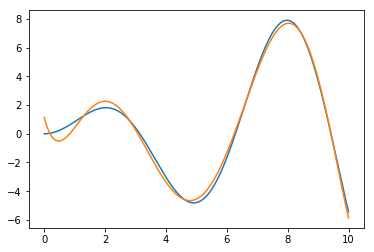

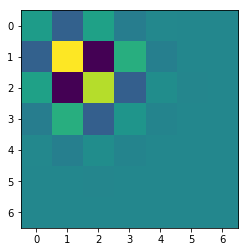

In [177]:
x_data = torch.linspace(0, 10, 1000)
y_data = x_data * torch.sin(x_data)

basis = [const, linear, quad, cubic, quartic, quintic, hextic]


design_mat = design_matrix(x_data, basis)
pseudo_inv = torch.linalg.pinv(design_mat)

fit_params = ls_fit(x_data, y_data, pseudo_inv)

fit = torch.sum(design_mat * fit_params, dim=1)

plt.plot(x_data, y_data)
plt.plot(x_data, fit)

plt.show()

fit_params_cov_mat = pseudo_inv @ (cov_mat @ pseudo_inv.T)

plt.imshow(fit_params_cov_mat)
plt.show()